References

- https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html
- https://github.com/tatsuyah/vehicle-detection
- https://github.com/qqwweee/keras-yolo3
- https://github.com/ablacklama/Vehicle-Detection

# 1. YOLO alogirthm

## 1.1 YOLO3 architecture

1. CNN, Resdiual Blocks, Skip Connections, Upsampling
2. Object detection, bounding box regression, IoU and non-maximum suppression.

- YOLOv3 contains 53 convolutional layers (stride 2), each followed by batch normalization layer and Leaky ReLU activation.
- If the stride of the network is 32, then an input image of size 416x416 will yield an output of size 13x13 (416/32=13).

- The input is a batch of images of shape (m, 416, 416, 3)
- The output is a list of bouding boxes along with the recognized classes. Each bounding box is represented by 6 numbers (pc, bx, by, bh, bw, c). If we expand c into an 80-dimensional vector, each bouding box is then representd by 85 numbers.

- In YOLO, the prediction is done by using a convolutional layer which uses 1x1 convolutions. So, the size of the prediction map is  exactly the size of the feature map before it.
- If we have (Bx(5+C)) entries in the feature map. B - number of bouding boxes each cell can predict, each of these B bouding boxed may specialize in detecting a certain kind of object.
- Each of the bouding boxed have 5 + C attributes, which describe the center coordinates, the dimensions, the objectness score and C class confidences for each bouding box. 
- YOLOv3 predicts 3 bouding boxes for every cell.

$$b_x = \sigma{t_x} + c_x$$
$$b_y = \sigma{t_y} + c_y$$
$$b_w = p_w e^{t_w}$$
$$b_h = p_h e^{t_h}$$

- bx, by, bw, bh are the x, y center coordinates, width and height.
- tx, ty, tw, th is the network output.
- cx, cy are the top-left coordinats of the grid 
- pw and ph are anchors dimensions for the box

Center Coordinates
- Center coordinates prediction are running through a sigmoid function, so the output is limited from 0 to 1.
- YOLO3 predicts offsets which are:
    - Relative to the top left corner of the grid cell which is predicting the object
    - Normalized by the dimensions of the cell from the feature map, which is, 1.


Dimensions of the Bouding Box
- Dimensions of the bounding box are predicted by applying a log-space transformation to the output and then multipying with an anchor

Objectness Score and Class Confidences 
- The objectness score is also passed through a sigmoid, as it is to be interpreted as a probability.


- YOLOv3 makes prediction across 3 different scales. The detection layer is used make detection at feature maps of three differen sizes, having strides 32, 16, 8 respectively. 
- With an input of 416x416, we make detections on scales 13x13, 26x26, 52x52.
- At each scale, each cell predicts 3 bouding boxes using 3 anchors, makeing the total number of anchots used 9.
- Output Processing (Filtering with a threshold on class scores)
    - For an image of size (416x416), YOLO predicts (52x52 + 26x26 13x13)x3 = 10647 bouding boxes.
    - First, we filter boxes on theris objectness score.
    - Then, Non-maximum Suppression
        - Select only one box when several boxes overlap with each other and detect the same object.

- box_confidence: contains pc
- boxes: contains (bx, by, bh, bw)
- box_class_probs: contain the detection probabilities (c1, ..., c80) for each 3 boxes per cell
- Select the box that has the highest score.
- Compute its overlap with all other boxes, and remove boxes that overlap it more than iou_threshold
- Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.
- Applying Intersection over Union (IoU).

In [93]:
from keras.models import load_model
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt  
from moviepy.editor import VideoFileClip, ImageClip
import time 

In [94]:
# convert.py 
model = load_model('yolov3_spp.h5')

In [95]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)//new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)//new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (new_w, new_h))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[(net_h-new_h)//2:(net_h+new_h)//2, (net_w-new_w)//2:(net_w+new_w)//2, :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

## 1.2 Decode Output of YOLOv3

In [96]:
def _sigmoid(x):
    # sigmoid for decoding the output
    return 1./(1.+np.exp(-x))

In [97]:
def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [98]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
        
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

In [99]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    # netout    : each output of the model - yolo3
    # anchors   : anchors of the model - defined in .cfg 
    # obj_thresh: threshold prediction score of target object
    # net_h     : input-height shape 
    # net_w     : input-width shape
    
    # height and width of features map
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    # each cell(anchor box) contains 3 boxes
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    # number of classes used
    nb_class = netout.shape[-1] - 5

    boxes = []
    # center and object score are passed through sigmoid function.
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    # objectness score * confidence = probabilities
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    # threshold
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i // grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[row, col, b, 4]
            
            if(objectness < obj_thresh): continue
            print(objectness)
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[row,col,b,:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[row,col,b,5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)

    return boxes

In [100]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [101]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [102]:
def get_color(label):
    if label < len(colors):
        return colors[label]
    else:
        print('Label {} has no color, returning default.'.format(label))
        return (0, 255, 0)

colors = [
    [31  , 0   , 255] ,
    [0   , 159 , 255] ,
    [255 , 95  , 0]   ,
    [255 , 19  , 0]   ,
    [255 , 0   , 0]   ,
    [255 , 38  , 0]   ,
    [0   , 255 , 25]  ,
    [255 , 0   , 133] ,
    [255 , 172 , 0]   ,
    [108 , 0   , 255] ,
    [0   , 82  , 255] ,
    [0   , 255 , 6]   ,
    [255 , 0   , 152] ,
    [223 , 0   , 255] ,
    [12  , 0   , 255] ,
    [0   , 255 , 178] ,
    [108 , 255 , 0]   ,
    [184 , 0   , 255] ,
    [255 , 0   , 76]  ,
    [146 , 255 , 0]   ,
    [51  , 0   , 255] ,
    [0   , 197 , 255] ,
    [255 , 248 , 0]   ,
    [255 , 0   , 19]  ,
    [255 , 0   , 38]  ,
    [89  , 255 , 0]   ,
    [127 , 255 , 0]   ,
    [255 , 153 , 0]   ,
    [0   , 255 , 255] ,
    [0   , 255 , 216] ,
    [0   , 255 , 121] ,
    [255 , 0   , 248] ,
    [70  , 0   , 255] ,
    [0   , 255 , 159] ,
    [0   , 216 , 255] ,
    [0   , 6   , 255] ,
    [0   , 63  , 255] ,
    [31  , 255 , 0]   ,
    [255 , 57  , 0]   ,
    [255 , 0   , 210] ,
    [0   , 255 , 102] ,
    [242 , 255 , 0]   ,
    [255 , 191 , 0]   ,
    [0   , 255 , 63]  ,
    [255 , 0   , 95]  ,
    [146 , 0   , 255] ,
    [184 , 255 , 0]   ,
    [255 , 114 , 0]   ,
    [0   , 255 , 235] ,
    [255 , 229 , 0]   ,
    [0   , 178 , 255] ,
    [255 , 0   , 114] ,
    [255 , 0   , 57]  ,
    [0   , 140 , 255] ,
    [0   , 121 , 255] ,
    [12  , 255 , 0]   ,
    [255 , 210 , 0]   ,
    [0   , 255 , 44]  ,
    [165 , 255 , 0]   ,
    [0   , 25  , 255] ,
    [0   , 255 , 140] ,
    [0   , 101 , 255] ,
    [0   , 255 , 82]  ,
    [223 , 255 , 0]   ,
    [242 , 0   , 255] ,
    [89  , 0   , 255] ,
    [165 , 0   , 255] ,
    [70  , 255 , 0]   ,
    [255 , 0   , 172] ,
    [255 , 76  , 0]   ,
    [203 , 255 , 0]   ,
    [204 , 0   , 255] ,
    [255 , 0   , 229] ,
    [255 , 133 , 0]   ,
    [127 , 0   , 255] ,
    [0   , 235 , 255] ,
    [0   , 255 , 197] ,
    [255 , 0   , 191] ,
    [0   , 44  , 255] ,
    [50  , 255 , 0]
]

In [103]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

In [104]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union


In [105]:
def draw_boxes(image, boxes, labels, obj_thresh, quiet=True):
    for box in boxes:
        label_str = ''
        label = -1
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                if label_str != '': label_str += ', '
                label_str += (labels[i] + ' ' + str(round(box.get_score()*100, 2)) + '%')
                label = i
            if not quiet: print(label_str)
                
        if label >= 0:
            text_size = cv2.getTextSize(label_str, cv2.FONT_HERSHEY_SIMPLEX, 1.1e-3 * image.shape[0], 5)
            width, height = text_size[0][0], text_size[0][1]
            region = np.array([[box.xmin-3,        box.ymin], 
                               [box.xmin-3,        box.ymin-height-26], 
                               [box.xmin+width+13, box.ymin-height-26], 
                               [box.xmin+width+13, box.ymin]], dtype='int32')  

            cv2.rectangle(img=image, pt1=(box.xmin,box.ymin), pt2=(box.xmax,box.ymax), color=get_color(label), thickness=5)
            cv2.fillPoly(img=image, pts=[region], color=get_color(label))
            cv2.putText(img=image, 
                        text=label_str, 
                        org=(box.xmin+13, box.ymin - 13), 
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale=1e-3 * image.shape[0], 
                        color=(0,0,0), 
                        thickness=2)
        
    return image          

(1, 416, 416, 3)
0.99563354
0.5800044
0.99457437
0.9912662
0.94686794
5
Label:  22
Score:  0.99563354
Label:  0
Score:  0.0
Label:  22
Score:  0.99457437
Label:  22
Score:  0.9912662
Label:  0
Score:  0.0


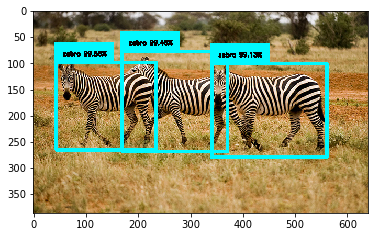

In [109]:
# show input image
test_image = cv2.imread('test_image_2.jpg')
image_w, image_h, _ = test_image.shape
input_image = preprocess_input(test_image, 416, 416)
print(input_image.shape)
# plt.imshow(test_image[0])
# Perform prediction on test image
netout = model.predict(input_image)

obj_thresh = 0.5
anchors = [[116,90,  156,198,  373,326], [30,61,  62,45,  59,119], [10,13,  16,30,  33,23,]]

boxes = []

for i in range(len(netout)):
    boxes += decode_netout(netout[i][0], anchors[i], obj_thresh, 416, 416)
print(len(boxes))

correct_yolo_boxes(boxes, image_w, image_h, 416, 416)
do_nms(boxes, 0.5)

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
targets = [0, 1, 2, 3, 5, 6, 7]
target_boxes = []
for box in boxes:
    print("Label: ", int(box.get_label()))
    print("Score: ", box.get_score())
    
rs_image = draw_boxes(test_image, boxes, labels, obj_thresh)
rs_image = cv2.cvtColor(rs_image, cv2.COLOR_BGR2RGB)
plt.imshow(rs_image)

In [110]:
# Sum up everything to 1 functions
def predict(image):
    # image     : using cv2.imread to load image
    # obj_thresh: object threshold 
    image_w, image_h, _ = image.shape
    input_image = preprocess_input(image, 416, 416)
    netout = model.predict(input_image)
    # 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
    
    # anchors of yolov3-tiny model [[81,82,  135,169,  344,319], [10,14,  23,27,  37,58]]
    anchors = [[116,90,  156,198,  373,326], [30,61,  62,45,  59,119], [10,13,  16,30,  33,23,]]
    # get bouding boxes
    boxes = []
    for i in range(len(netout)):
        boxes += decode_netout(netout[i][0], anchors[i], 0.6, 416, 416)
    correct_yolo_boxes(boxes, image_w, image_h, 416, 416)
    # non-maximum suppression
    do_nms(boxes, 0.5)
    # labels follow coco dataset
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
        "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
        "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
        "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
        "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
        "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
        "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
        "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
        "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    rs_image = draw_boxes(image, boxes, labels, obj_thresh)
    rs_image = rs_image.astype('uint8')
    
    return rs_image

0.6711256
0.89218974
0.9992505


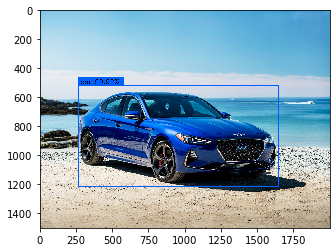

In [111]:
test_image = cv2.imread('test_image_1.jpg')
plt.imshow(cv2.cvtColor(predict(test_image), cv2.COLOR_BGR2RGB))

## 1.3 Apply YOLOv3 to video 

### Sequence of images 

### Video 

In [33]:
history = deque(maxlen = 8)
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(predict)
%time video_clip.write_videofile(output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video result.mp4.
Moviepy - Writing video result.mp4




t:   5%|███▌                                                               | 67/1260 [00:15<04:14,  4.69it/s, now=None]


t:  11%|██████▉                                                           | 133/1260 [00:29<04:00,  4.70it/s, now=None]


t:  16%|██████████▍                                                       | 199/1260 [00:43<03:40,  4.82it/s, now=None]


t:  21%|█████████████▉                                                    | 265/1260 [00:57<03:27,  4.80it/s, now=None]


t:  26%|█████████████████▎                                                | 331/1260 [01:11<03:13,  4.79it/s, now=None]


t:  32%|████████████████████▊                                             | 397/1260 [01:25<03:05,  4.66it/s, now=None]


t:  37%|████████████████████████▎                                         | 463/1260 [01:39<02:47,  4.74it/s, now=None]


t:  42%|███████████████████████████▋                                      | 529/1260 [01:53<02:35,  4.71it/s, now=None]


t:  47%|███████████████████████████████▏                                  | 595/1260 [02:07<02:22,  4.65it/s, now=None]


t:  52%|██████████████████████████████████▌                               | 661/1260 [02:21<02:08,  4.65it/s, now=None]


t:  58%|██████████████████████████████████████                            | 727/1260 [02:37<02:11,  4.05it/s, now=None]


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [02:54<02:09,  3.61it/s, now=None]


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [03:12<01:42,  3.90it/s, now=None]


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [03:28<01:16,  4.37it/s, now=None]


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [03:45<01:07,  3.96it/s, now=None]


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [04:02<00:48,  4.19it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [04:18<00:35,  3.89it/s, now=None]


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [04:37<00:19,  3.66it/s, now=None]


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [04:54<00:01,  4.15it/s, now=None]


t:  48%|███████████████████████████████▌                                  | 602/1260 [17:21<02:41,  4.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready result.mp4
Wall time: 4min 57s


## Response to the Event 

Decided based on 
- Center and area of the bouding box.
- Speed estimation of the detected object. 


Output can be: Straight, Left, Right, Stop.

In [112]:
# Sum up everything to 1 functions
def predict_for_response(image):
    image_w, image_h, _ = image.shape
    input_image = preprocess_input(image, 416, 416)
    netout = model.predict(input_image)
 
    anchors = [[116,90,  156,198,  373,326], [30,61,  62,45,  59,119], [10,13,  16,30,  33,23,]]
    # get bouding boxes
    boxes = []
    for i in range(len(netout)):
        boxes += decode_netout(netout[i][0], anchors[i], 0.7, 416, 416)
    target_boxes = []
    for box in boxes:
        if (box.get_score() > 7):
            continue
        target_boxes.append(box)
    do_nms(target_boxes, 0.5)
    correct_yolo_boxes(target_boxes, image_w, image_h, 416, 416)
    
    # labels follow coco dataset
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck"]
    
    image_with_boxes = draw_boxes(image, target_boxes, labels, obj_thresh)
    image_with_boxes = image_with_boxes.astype('uint8')
    
    center_x, center_y, width, height = [], [], [], []
    
    for box in target_boxes:
        center_x.append((box.xmin + box.xmax)/2)
        center_y.append((box.ymin + box.ymax)/2)
        width.append((box.xmax - box.xmin))
        height.append((box.ymax - box.ymin))
    
    return image_with_boxes, len(target_boxes), center_x, center_y, width, height

0.985436
0.9816565
0.93226796
0.999329
0.8602381
Center:  992.5 , 287.0 Width:  461 Height: 164
Center:  395.5 , 230.0 Width:  215 Height: 134
Center:  396.0 , 238.0 Width:  214 Height: 148
Center:  127.5 , 294.0 Width:  243 Height: 154
Center:  679.0 , 206.5 Width:  62 Height: 49


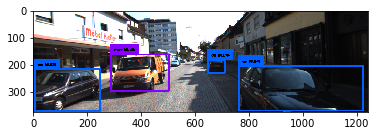

In [113]:
image = cv2.imread("test_image_3.png")
image_with_boxes, nb_box, center_x, center_y, width, height = predict_for_response(image)
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
for i in range(nb_box):
    print("Center: ", center_x[i], ",", center_y[i], "Width: ", width[i], "Height:", height[i])